In [1]:
import joblib

#joblib.parallel_backend("threading")

In [2]:
"""
%cd /kaggle/working
#!git clone https://github.com/R-N/ml-utility-loss
%cd ml-utility-loss
!git pull
#!pip install .
!pip install . --no-deps --force-reinstall --upgrade
#"""

'\n%cd /kaggle/working\n#!git clone https://github.com/R-N/ml-utility-loss\n%cd ml-utility-loss\n!git pull\n#!pip install .\n!pip install . --no-deps --force-reinstall --upgrade\n#'

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [3,3]

In [4]:
datasets = [
    "insurance",
    "treatment",
    "contraceptive"
]

study_dir = "./"

In [5]:
#Parameters
import os

path_prefix = "../../../../"

dataset_dir = os.path.join(path_prefix, "ml-utility-loss/datasets")
dataset_name = "treatment"
model_name="ml_utility_2"
models = ["tvae", "realtabformer", "lct_gan", "tab_ddpm_concat"]
single_model = "lct_gan"
random_seed = 42
gp = True
gp_multiply = True
folder = "eval"
debug = False
path = None
param_index = 0

In [6]:
# Parameters
dataset = "contraceptive"
dataset_name = "contraceptive"
single_model = "lct_gan"
gp = False
gp_multiply = False
random_seed = 42
debug = False
folder = "eval"
path_prefix = "../../../../"
path = "eval/contraceptive/lct_gan/42"
param_index = 2


In [7]:
from pathlib import Path
import os

%cd /kaggle/working/

if path is None:
    path = os.path.join(folder, dataset_name, single_model, random_seed)
Path(path).mkdir(parents=True, exist_ok=True)

%cd {path}

/kaggle/working
/kaggle/working/eval/contraceptive/lct_gan/42


In [8]:
from ml_utility_loss.util import seed
if single_model:
    model_name=f"{model_name}_{single_model}"
if random_seed is not None:
    seed(random_seed)
    print("Set seed to", seed)

Set seed to <function seed at 0x7e1e71cf23b0>


In [9]:
import pandas as pd
import numpy as np
import json
import os

df = pd.read_csv(os.path.join(dataset_dir, f"{dataset_name}.csv"))
with open(os.path.join(dataset_dir, f"{dataset_name}.json")) as f:
    info = json.load(f)

In [10]:
task = info["task"]
target = info["target"]
cat_features = info["cat_features"]
mixed_features = info["mixed_features"]
longtail_features = info["longtail_features"]
integer_features = info["integer_features"]

test = df.sample(frac=0.2, random_state=42)
train = df[~df.index.isin(test.index)]

In [11]:
import ml_utility_loss.synthesizers.tab_ddpm.params as TAB_DDPM_PARAMS
import ml_utility_loss.synthesizers.lct_gan.params as LCT_GAN_PARAMS
import ml_utility_loss.synthesizers.realtabformer.params as RTF_PARAMS
from ml_utility_loss.synthesizers.realtabformer.params.default import GPT2_PARAMS, REALTABFORMER_PARAMS
from ml_utility_loss.util import filter_dict_2, filter_dict

tab_ddpm_params = getattr(TAB_DDPM_PARAMS, dataset_name).BEST
lct_gan_params = getattr(LCT_GAN_PARAMS, dataset_name).BEST
lct_ae_params = filter_dict_2(lct_gan_params, LCT_GAN_PARAMS.default.AE_PARAMS)
rtf_params = getattr(RTF_PARAMS, dataset_name).BEST
rtf_params = filter_dict(rtf_params, REALTABFORMER_PARAMS)

lct_ae_embedding_size=lct_gan_params["embedding_size"]
tab_ddpm_normalization="quantile"
tab_ddpm_cat_encoding=tab_ddpm_params["cat_encoding"]
#tab_ddpm_cat_encoding="one-hot"
tab_ddpm_y_policy="default"
tab_ddpm_is_y_cond=True

In [12]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_lct_ae

lct_ae = load_lct_ae(
    dataset_name=dataset_name,
    model_dir=os.path.join(path_prefix, "ml-utility-loss/models"),
    model_name="lct_ae",
    df_name="df",
)
lct_ae = None

2024-03-01 17:33:58.910176: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 17:33:58.910280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 17:33:59.040427: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_rtf_embed

rtf_embed = load_rtf_embed(
    dataset_name=dataset_name,
    model_dir=os.path.join(path_prefix, "ml-utility-loss/models"),
    model_name="realtabformer",
    df_name="df",
    ckpt_type="best-disc-model"
)

In [14]:
from ml_utility_loss.loss_learning.estimator.preprocessing import DataPreprocessor

preprocessor = DataPreprocessor(
    task,
    target=target,
    cat_features=cat_features,
    mixed_features=mixed_features,
    longtail_features=longtail_features,
    integer_features=integer_features,
    lct_ae_embedding_size=lct_ae_embedding_size,
    lct_ae_params=lct_ae_params,
    lct_ae=lct_ae,
    tab_ddpm_normalization=tab_ddpm_normalization,
    tab_ddpm_cat_encoding=tab_ddpm_cat_encoding,
    tab_ddpm_y_policy=tab_ddpm_y_policy,
    tab_ddpm_is_y_cond=tab_ddpm_is_y_cond,
    realtabformer_embedding=rtf_embed,
    realtabformer_params=rtf_params,
)
preprocessor.fit(df)

/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  .fit(X)
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  .fit(X)


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  .fit(X)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.99s/it]

100%|██████████| 1/1 [00:02<00:00,  2.99s/it]

In [15]:
preprocessor.adapter_sizes

{'tvae': 46,
 'realtabformer': (24, 72, Embedding(72, 672), True),
 'lct_gan': 40,
 'tab_ddpm_concat': 10}

In [16]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_dataset_3_factory

datasetsn = load_dataset_3_factory(
    dataset_dir=os.path.join(path_prefix, "ml-utility-loss/"),
    dataset_name=dataset_name,
    preprocessor=preprocessor,
    cache_dir=path_prefix,
)


In [17]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_dataset

test_set = load_dataset(
    dataset_dir=os.path.join(path_prefix, "ml-utility-loss/", "datasets_5", dataset_name),
    preprocessor=preprocessor,
    cache_dir=os.path.join(path_prefix, dataset_name, "_cache_test"),
    start=200,
    #stop=600,
    val=False,
    ratio=0,
    drop_first_column=True,
    model=single_model,
)

Caching in ../../../../contraceptive/_cache_test/lct_gan/all inf False


In [18]:
import ml_utility_loss.loss_learning.estimator.params2 as PARAMS
from ml_utility_loss.tuning import map_parameters
from ml_utility_loss.loss_learning.estimator.params.default import update_param_space, update_param_space_2
import wandb

#"""
param_space = {
    **getattr(PARAMS, dataset_name).PARAM_SPACE,
}
params = {
    **getattr(PARAMS, dataset_name).BESTS[param_index],
}
if gp:
    params["gradient_penalty_mode"] = "ALL"
    params["mse_mag"] = True
    if gp_multiply:
        params["mse_mag_multiply"] = True
        params["mse_mag_target"] = 1.0
    else:
        params["mse_mag_multiply"] = False
        params["mse_mag_target"] = 0.1
else:
    params["gradient_penalty_mode"] = "NONE"
    params["mse_mag"] = False
params["single_model"] = False
if models:
    params["models"] = models
if single_model:
    params["fixed_role_model"] = single_model
    params["single_model"] = True
    params["models"] = [single_model]
if params["fixed_role_model"] == "realtabformer" and dataset_name == "treatment":
    params["batch_size"] = 2
params["max_seconds"] = 3600
params["patience"] = 10
params["epochs"] = 100
if debug:
    params["epochs"] = 2
with open("params.json", "w") as f:
    json.dump(params, f)
params = map_parameters(params, param_space=param_space)
params

{'Body': 'twin_encoder',
 'loss_balancer_meta': True,
 'loss_balancer_log': False,
 'loss_balancer_lbtw': False,
 'pma_skip_small': False,
 'isab_skip_small': False,
 'layer_norm': False,
 'pma_layer_norm': False,
 'attn_residual': True,
 'tf_n_layers_dec': False,
 'tf_isab_rank': 0,
 'tf_layer_norm': False,
 'tf_pma_start': -1,
 'head_n_seeds': 0,
 'tf_pma_low': 8,
 'dropout': 0,
 'combine_mode': 'diff_left',
 'tf_isab_mode': 'separate',
 'grad_loss_fn': <function torch.nn.functional.l1_loss(input: torch.Tensor, target: torch.Tensor, size_average: Optional[bool] = None, reduce: Optional[bool] = None, reduction: str = 'mean') -> torch.Tensor>,
 'single_model': True,
 'bias': True,
 'bias_final': True,
 'pma_ffn_mode': 'shared',
 'patience': 10,
 'inds_init_mode': 'fixnorm',
 'grad_clip': 0.775,
 'gradient_penalty_mode': {'gradient_penalty': False,
  'calc_grad_m': False,
  'avg_non_role_model_m': False,
  'inverse_avg_non_role_model_m': False},
 'synth_data': 2,
 'dataset_size': 2048,


In [19]:
train_set, val_set = datasetsn(model=params["fixed_role_model"], synth_data=params["synth_data"])

load_dataset_3_factory 2
Caching in ../../../../contraceptive/_cache/lct_gan/all inf False
Splitting without random!
Split with reverse index!
../../../../ml-utility-loss/datasets_2/contraceptive [80, 20]
Caching in ../../../../contraceptive/_cache4/lct_gan/all inf False
Splitting without random!
Split with reverse index!
../../../../ml-utility-loss/datasets_4/contraceptive [80, 20]
Caching in ../../../../contraceptive/_cache5/lct_gan/all inf False
Splitting without random!
Split with reverse index!
../../../../ml-utility-loss/datasets_5/contraceptive [160, 40]
[320, 80]
[320, 80]


In [20]:
from ml_utility_loss.loss_learning.estimator.model.pipeline import remove_non_model_params
from ml_utility_loss.loss_learning.estimator.pipeline import create_model
from ml_utility_loss.util import filter_dict, clear_memory

clear_memory()

params2 = remove_non_model_params(params)
adapters = filter_dict(preprocessor.adapter_sizes, params["models"])

model = create_model(
    adapters=adapters,
    #Body="twin_encoder",
    **params2,
)
#cf.apply_weight_standardization(model, n_last_layers_ignore=0)
print(model.models, len(model.adapters))

Creating model of type <class 'ml_utility_loss.loss_learning.estimator.model.models.TwinEncoder'>


[*] Embedding False True
['lct_gan'] 1


In [21]:
study_name=f"{model_name}_{dataset_name}"

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

10264072

In [23]:
from torchinfo import summary

role_model = params["fixed_role_model"]
s = train_set[0][role_model]
summary(model[role_model], input_size=((2, *s[0].shape), (2, *s[1].shape)), depth=9) # 8 max

Layer (type:depth-idx)                                                 Output Shape              Param #
MLUtilitySingle                                                        [2, 1179, 40]             --
├─Adapter: 1-1                                                         [2, 1179, 40]             --
│    └─Sequential: 2-1                                                 [2, 1179, 256]            --
│    │    └─FeedForward: 3-1                                           [2, 1179, 1024]           --
│    │    │    └─Linear: 4-1                                           [2, 1179, 1024]           41,984
│    │    │    └─Softsign: 4-2                                         [2, 1179, 1024]           --
│    │    └─FeedForward: 3-2                                           [2, 1179, 1024]           --
│    │    │    └─Linear: 4-3                                           [2, 1179, 1024]           1,049,600
│    │    │    └─Softsign: 4-4                                         [2, 1179, 102

In [24]:
import torch
from ml_utility_loss.loss_learning.estimator.pipeline import train, train_2
from ml_utility_loss.loss_learning.estimator.process_simple import train_epoch, eval as _eval
from ml_utility_loss.params import GradientPenaltyMode
from ml_utility_loss.util import clear_memory
import time
#torch.autograd.set_detect_anomaly(True)

clear_memory()

opt = params["Optim"](model.parameters())
loss = train_2(
    [train_set, val_set, test_set],
    preprocessor=preprocessor,
    whole_model=model,
    optim=opt,
    log_dir="logs",
    checkpoint_dir="checkpoints",
    verbose=True,
    allow_same_prediction=False,
    wandb=wandb,
    study_name=study_name,
    **params
)

wandb: Tracking run with wandb version 0.16.3


wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


g_loss_mul 0.1
Epoch 0


Train loss {'avg_role_model_loss': 0.01786272754015954, 'avg_role_model_std_loss': 3.636569730948348, 'avg_role_model_mean_pred_loss': 0.001167070859791755, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.01786272754015954, 'n_size': 320, 'n_batch': 160, 'duration': 162.09109449386597, 'duration_batch': 1.0130693405866622, 'duration_size': 0.5065346702933311, 'avg_pred_std': 0.07982906211551608}


Val loss {'avg_role_model_loss': 0.0036570764575117208, 'avg_role_model_std_loss': 8.543643573567897, 'avg_role_model_mean_pred_loss': 1.3811252661610762e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0036570764575117208, 'n_size': 80, 'n_batch': 40, 'duration': 38.24689245223999, 'duration_batch': 0.9561723113059998, 'duration_size': 0.4780861556529999, 'avg_pred_std': 0.013961730610299128}
Epoch 1


Train loss {'avg_role_model_loss': 0.005696987385198327, 'avg_role_model_std_loss': 3.198073918344037, 'avg_role_model_mean_pred_loss': 6.659749155254468e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.005696987385198327, 'n_size': 320, 'n_batch': 160, 'duration': 161.77688694000244, 'duration_batch': 1.0111055433750153, 'duration_size': 0.5055527716875077, 'avg_pred_std': 0.06436048086907249}


Val loss {'avg_role_model_loss': 0.003786977470736019, 'avg_role_model_std_loss': 3.9373093709834395, 'avg_role_model_mean_pred_loss': 1.9986069321897836e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.003786977470736019, 'n_size': 80, 'n_batch': 40, 'duration': 38.12403869628906, 'duration_batch': 0.9531009674072266, 'duration_size': 0.4765504837036133, 'avg_pred_std': 0.019040833081817254}
Epoch 2


Train loss {'avg_role_model_loss': 0.0032535013802828415, 'avg_role_model_std_loss': 2.8198290220143503, 'avg_role_model_mean_pred_loss': 1.6548445633081822e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0032535013802828415, 'n_size': 320, 'n_batch': 160, 'duration': 158.56593680381775, 'duration_batch': 0.9910371050238609, 'duration_size': 0.49551855251193044, 'avg_pred_std': 0.05899094843493913}


Val loss {'avg_role_model_loss': 0.002633672622323502, 'avg_role_model_std_loss': 4.367062080342106, 'avg_role_model_mean_pred_loss': 6.056017390343449e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002633672622323502, 'n_size': 80, 'n_batch': 40, 'duration': 36.21775007247925, 'duration_batch': 0.9054437518119812, 'duration_size': 0.4527218759059906, 'avg_pred_std': 0.029313163098959195}
Epoch 3


Train loss {'avg_role_model_loss': 0.0023438148911395728, 'avg_role_model_std_loss': 2.2918122927125295, 'avg_role_model_mean_pred_loss': 7.134696727795209e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0023438148911395728, 'n_size': 320, 'n_batch': 160, 'duration': 152.8709909915924, 'duration_batch': 0.9554436936974525, 'duration_size': 0.47772184684872626, 'avg_pred_std': 0.06780749239678699}


Val loss {'avg_role_model_loss': 0.002467950962409304, 'avg_role_model_std_loss': 4.88692410795129, 'avg_role_model_mean_pred_loss': 4.36867752655612e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002467950962409304, 'n_size': 80, 'n_batch': 40, 'duration': 35.697052240371704, 'duration_batch': 0.8924263060092926, 'duration_size': 0.4462131530046463, 'avg_pred_std': 0.018721673299660326}
Epoch 4


Train loss {'avg_role_model_loss': 0.002259014635501444, 'avg_role_model_std_loss': 1.812988119399502, 'avg_role_model_mean_pred_loss': 5.5367047818208335e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002259014635501444, 'n_size': 320, 'n_batch': 160, 'duration': 151.4134497642517, 'duration_batch': 0.9463340610265731, 'duration_size': 0.47316703051328657, 'avg_pred_std': 0.06716944240579323}


Val loss {'avg_role_model_loss': 0.0023299435670196544, 'avg_role_model_std_loss': 7.427999823173169, 'avg_role_model_mean_pred_loss': 6.818181761379086e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0023299435670196544, 'n_size': 80, 'n_batch': 40, 'duration': 36.091819047927856, 'duration_batch': 0.9022954761981964, 'duration_size': 0.4511477380990982, 'avg_pred_std': 0.025550102235138185}
Epoch 5


Train loss {'avg_role_model_loss': 0.002213509789987711, 'avg_role_model_std_loss': 2.1981050524016665, 'avg_role_model_mean_pred_loss': 6.457744553583708e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002213509789987711, 'n_size': 320, 'n_batch': 160, 'duration': 155.00266909599304, 'duration_batch': 0.9687666818499565, 'duration_size': 0.48438334092497826, 'avg_pred_std': 0.06307913716664189}


Val loss {'avg_role_model_loss': 0.0025578231319741463, 'avg_role_model_std_loss': 5.699148117736866, 'avg_role_model_mean_pred_loss': 7.032264796913435e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0025578231319741463, 'n_size': 80, 'n_batch': 40, 'duration': 35.88962531089783, 'duration_batch': 0.8972406327724457, 'duration_size': 0.44862031638622285, 'avg_pred_std': 0.017301402381235675}
Epoch 6


Train loss {'avg_role_model_loss': 0.002113006258792893, 'avg_role_model_std_loss': 2.1890728188584476, 'avg_role_model_mean_pred_loss': 6.114715563168734e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002113006258792893, 'n_size': 320, 'n_batch': 160, 'duration': 153.502343416214, 'duration_batch': 0.9593896463513374, 'duration_size': 0.4796948231756687, 'avg_pred_std': 0.0661177773316524}


Val loss {'avg_role_model_loss': 0.0022539663767020103, 'avg_role_model_std_loss': 8.082782875575992, 'avg_role_model_mean_pred_loss': 6.678637441320801e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0022539663767020103, 'n_size': 80, 'n_batch': 40, 'duration': 35.9239776134491, 'duration_batch': 0.8980994403362275, 'duration_size': 0.44904972016811373, 'avg_pred_std': 0.025397659230247883}
Epoch 7


Train loss {'avg_role_model_loss': 0.0018896224307241027, 'avg_role_model_std_loss': 1.3406870565765918, 'avg_role_model_mean_pred_loss': 4.11630951652614e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0018896224307241027, 'n_size': 320, 'n_batch': 160, 'duration': 151.49836015701294, 'duration_batch': 0.9468647509813308, 'duration_size': 0.4734323754906654, 'avg_pred_std': 0.07347480687003553}


Val loss {'avg_role_model_loss': 0.0025110580976615894, 'avg_role_model_std_loss': 5.483385282401798, 'avg_role_model_mean_pred_loss': 4.007785178927748e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0025110580976615894, 'n_size': 80, 'n_batch': 40, 'duration': 33.77740168571472, 'duration_batch': 0.844435042142868, 'duration_size': 0.422217521071434, 'avg_pred_std': 0.01343663605657639}
Epoch 8


Train loss {'avg_role_model_loss': 0.0019506988204057052, 'avg_role_model_std_loss': 1.1689463564448361, 'avg_role_model_mean_pred_loss': 4.559629974733976e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0019506988204057052, 'n_size': 320, 'n_batch': 160, 'duration': 144.0004370212555, 'duration_batch': 0.9000027313828468, 'duration_size': 0.4500013656914234, 'avg_pred_std': 0.0659007933063549}


Val loss {'avg_role_model_loss': 0.0023398275739964446, 'avg_role_model_std_loss': 4.280078241747558, 'avg_role_model_mean_pred_loss': 9.40580381603908e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0023398275739964446, 'n_size': 80, 'n_batch': 40, 'duration': 34.14411234855652, 'duration_batch': 0.8536028087139129, 'duration_size': 0.42680140435695646, 'avg_pred_std': 0.029161113313784882}
Epoch 9


Train loss {'avg_role_model_loss': 0.0016659495725662055, 'avg_role_model_std_loss': 1.259914455004442, 'avg_role_model_mean_pred_loss': 3.6357496224758216e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0016659495725662055, 'n_size': 320, 'n_batch': 160, 'duration': 146.88511276245117, 'duration_batch': 0.9180319547653198, 'duration_size': 0.4590159773826599, 'avg_pred_std': 0.06927311308209028}


Val loss {'avg_role_model_loss': 0.0020320220184657954, 'avg_role_model_std_loss': 1.9301895227664638, 'avg_role_model_mean_pred_loss': 5.797358790626817e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0020320220184657954, 'n_size': 80, 'n_batch': 40, 'duration': 33.82334542274475, 'duration_batch': 0.8455836355686188, 'duration_size': 0.4227918177843094, 'avg_pred_std': 0.031894830953388006}
Epoch 10


Train loss {'avg_role_model_loss': 0.0016075492954826132, 'avg_role_model_std_loss': 1.0092837510064634, 'avg_role_model_mean_pred_loss': 2.735296125088143e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0016075492954826132, 'n_size': 320, 'n_batch': 160, 'duration': 143.3337082862854, 'duration_batch': 0.8958356767892838, 'duration_size': 0.4479178383946419, 'avg_pred_std': 0.07756731488425431}


Val loss {'avg_role_model_loss': 0.0026302734650016646, 'avg_role_model_std_loss': 3.5820208163912866, 'avg_role_model_mean_pred_loss': 1.3108698285635434e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0026302734650016646, 'n_size': 80, 'n_batch': 40, 'duration': 33.34847378730774, 'duration_batch': 0.8337118446826934, 'duration_size': 0.4168559223413467, 'avg_pred_std': 0.026611345619312488}
Epoch 11


Train loss {'avg_role_model_loss': 0.0013905711543884536, 'avg_role_model_std_loss': 1.4293391600536105, 'avg_role_model_mean_pred_loss': 1.9943211839244628e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0013905711543884536, 'n_size': 320, 'n_batch': 160, 'duration': 145.80800819396973, 'duration_batch': 0.9113000512123108, 'duration_size': 0.4556500256061554, 'avg_pred_std': 0.07521452093462813}


Val loss {'avg_role_model_loss': 0.0022007888529515184, 'avg_role_model_std_loss': 4.483247433313909, 'avg_role_model_mean_pred_loss': 7.529547302986828e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0022007888529515184, 'n_size': 80, 'n_batch': 40, 'duration': 34.17486619949341, 'duration_batch': 0.8543716549873352, 'duration_size': 0.4271858274936676, 'avg_pred_std': 0.025888706676232685}
Epoch 12


Train loss {'avg_role_model_loss': 0.0012333092558833413, 'avg_role_model_std_loss': 1.0602984449560355, 'avg_role_model_mean_pred_loss': 1.4978945140242672e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0012333092558833413, 'n_size': 320, 'n_batch': 160, 'duration': 144.26001048088074, 'duration_batch': 0.9016250655055046, 'duration_size': 0.4508125327527523, 'avg_pred_std': 0.06890693796813138}


Val loss {'avg_role_model_loss': 0.002605481748287275, 'avg_role_model_std_loss': 5.8101766740395275, 'avg_role_model_mean_pred_loss': 1.2162480100338935e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002605481748287275, 'n_size': 80, 'n_batch': 40, 'duration': 34.0310595035553, 'duration_batch': 0.8507764875888825, 'duration_size': 0.42538824379444123, 'avg_pred_std': 0.030725552017582914}
Epoch 13


Train loss {'avg_role_model_loss': 0.0011501418213924809, 'avg_role_model_std_loss': 1.3386667872641667, 'avg_role_model_mean_pred_loss': 1.3185595447717802e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0011501418213924809, 'n_size': 320, 'n_batch': 160, 'duration': 144.17591977119446, 'duration_batch': 0.9010994985699654, 'duration_size': 0.4505497492849827, 'avg_pred_std': 0.07558018262188852}


Val loss {'avg_role_model_loss': 0.0022788071105424024, 'avg_role_model_std_loss': 2.7987204812981075, 'avg_role_model_mean_pred_loss': 7.67833690556996e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0022788071105424024, 'n_size': 80, 'n_batch': 40, 'duration': 34.57782983779907, 'duration_batch': 0.8644457459449768, 'duration_size': 0.4322228729724884, 'avg_pred_std': 0.028933984229661293}
Epoch 14


Train loss {'avg_role_model_loss': 0.0010513833095672, 'avg_role_model_std_loss': 0.6387672975999288, 'avg_role_model_mean_pred_loss': 1.4141241849948554e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0010513833095672, 'n_size': 320, 'n_batch': 160, 'duration': 145.27083349227905, 'duration_batch': 0.907942709326744, 'duration_size': 0.453971354663372, 'avg_pred_std': 0.07942418371021631}


Val loss {'avg_role_model_loss': 0.0023162082296039445, 'avg_role_model_std_loss': 3.349859969510388, 'avg_role_model_mean_pred_loss': 8.629114276192951e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0023162082296039445, 'n_size': 80, 'n_batch': 40, 'duration': 33.332454442977905, 'duration_batch': 0.8333113610744476, 'duration_size': 0.4166556805372238, 'avg_pred_std': 0.03227444588264916}
Epoch 15


Train loss {'avg_role_model_loss': 0.0009490251221507151, 'avg_role_model_std_loss': 0.6831669182588915, 'avg_role_model_mean_pred_loss': 1.0006828890851693e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0009490251221507151, 'n_size': 320, 'n_batch': 160, 'duration': 145.07566261291504, 'duration_batch': 0.906722891330719, 'duration_size': 0.4533614456653595, 'avg_pred_std': 0.08901288353954442}


Val loss {'avg_role_model_loss': 0.002519568522711779, 'avg_role_model_std_loss': 3.413597872712374, 'avg_role_model_mean_pred_loss': 1.3267886331692902e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002519568522711779, 'n_size': 80, 'n_batch': 40, 'duration': 35.61937355995178, 'duration_batch': 0.8904843389987945, 'duration_size': 0.44524216949939727, 'avg_pred_std': 0.03244233850882665}
Epoch 16


Train loss {'avg_role_model_loss': 0.0008506465366181715, 'avg_role_model_std_loss': 0.6938899818249922, 'avg_role_model_mean_pred_loss': 7.591354541367547e-07, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0008506465366181715, 'n_size': 320, 'n_batch': 160, 'duration': 141.91219687461853, 'duration_batch': 0.8869512304663658, 'duration_size': 0.4434756152331829, 'avg_pred_std': 0.07522430039280152}


Val loss {'avg_role_model_loss': 0.0022380605670150543, 'avg_role_model_std_loss': 2.3211301649584923, 'avg_role_model_mean_pred_loss': 8.706937260289163e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0022380605670150543, 'n_size': 80, 'n_batch': 40, 'duration': 33.153270959854126, 'duration_batch': 0.8288317739963531, 'duration_size': 0.41441588699817655, 'avg_pred_std': 0.033504872786579654}
Epoch 17


Train loss {'avg_role_model_loss': 0.0007984611616791426, 'avg_role_model_std_loss': 0.8550257516943558, 'avg_role_model_mean_pred_loss': 6.954888952128042e-07, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0007984611616791426, 'n_size': 320, 'n_batch': 160, 'duration': 141.78189277648926, 'duration_batch': 0.8861368298530579, 'duration_size': 0.44306841492652893, 'avg_pred_std': 0.07633930989904911}


Val loss {'avg_role_model_loss': 0.0023599293230745387, 'avg_role_model_std_loss': 2.454739641254777, 'avg_role_model_mean_pred_loss': 1.1268823242671644e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0023599293230745387, 'n_size': 80, 'n_batch': 40, 'duration': 33.33975076675415, 'duration_batch': 0.8334937691688538, 'duration_size': 0.4167468845844269, 'avg_pred_std': 0.03295552866329672}
Epoch 18


Train loss {'avg_role_model_loss': 0.0007362112768333872, 'avg_role_model_std_loss': 1.1732242802433412, 'avg_role_model_mean_pred_loss': 4.6208515920671473e-07, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0007362112768333872, 'n_size': 320, 'n_batch': 160, 'duration': 142.94105648994446, 'duration_batch': 0.8933816030621529, 'duration_size': 0.44669080153107643, 'avg_pred_std': 0.07887016502173765}


Val loss {'avg_role_model_loss': 0.0022324465072415477, 'avg_role_model_std_loss': 2.106721719149411, 'avg_role_model_mean_pred_loss': 9.551615076732606e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0022324465072415477, 'n_size': 80, 'n_batch': 40, 'duration': 33.48200488090515, 'duration_batch': 0.8370501220226287, 'duration_size': 0.41852506101131437, 'avg_pred_std': 0.031034307027584872}
Epoch 19


wandb:                                                                                


Train loss {'avg_role_model_loss': 0.0006516361492984402, 'avg_role_model_std_loss': 0.5988772722470912, 'avg_role_model_mean_pred_loss': 3.690359887095372e-07, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0006516361492984402, 'n_size': 320, 'n_batch': 160, 'duration': 142.92735695838928, 'duration_batch': 0.893295980989933, 'duration_size': 0.4466479904949665, 'avg_pred_std': 0.07815303717216011}
Time out: 3692.50643992424/3600


wandb: 
wandb: Run history:
wandb:                       avg_loss_test ▇█▃▃▂▃▂▃▂▁▃▂▃▂▂▃▂▂▂
wandb:                      avg_loss_train █▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
wandb:  avg_non_role_model_embed_loss_test ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: avg_non_role_model_embed_loss_train ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:  avg_non_role_model_g_cos_loss_test ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: avg_non_role_model_g_cos_loss_train ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:  avg_non_role_model_g_mag_loss_test ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: avg_non_role_model_g_mag_loss_train ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                   avg_pred_std_test ▁▃▇▃▅▂▅▁▆▇▆▅▇▆████▇
wandb:                  avg_pred_std_train ▆▂▁▃▃▂▃▄▃▃▅▅▃▅▆█▅▅▆
wandb:      avg_role_model_g_cos_loss_test ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:     avg_role_model_g_cos_loss_train ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:      avg_role_model_g_mag_loss_test ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:     avg_role_model_g_mag_loss_train ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:            avg_role_model_loss_test ▇█▃▃▂▃▂▃▂▁▃▂▃▂▂▃▂▂▂
wandb:           avg_role_m

wandb: You can sync this run to the cloud by running:
wandb: wandb sync /kaggle/working/eval/contraceptive/lct_gan/42/wandb/offline-run-20240301_173421-7wshd8vd


wandb: Find logs at: ./wandb/offline-run-20240301_173421-7wshd8vd/logs


/opt/conda/lib/python3.10/site-packages/ml_utility_loss/loss_learning/estimator/process.py:348: UserWarning: cov(): degrees of freedom is <= 0 (Triggered internally at ../aten/src/ATen/native/Correlation.cpp:100.)
  corr_mat = torch.corrcoef(stack)


Eval loss {'role_model': 'lct_gan', 'n_size': 399, 'n_batch': 200, 'role_model_metrics': {'avg_loss': 0.0012717791214527097, 'avg_g_mag_loss': nan, 'avg_g_cos_loss': 0.012063155442658336, 'pred_duration': 3.151550769805908, 'grad_duration': 2.571305990219116, 'total_duration': 5.722856760025024, 'pred_std': 0.05481971800327301, 'std_loss': 0.022213952615857124, 'mean_pred_loss': 1.6693775251042098e-06, 'pred_rmse': 0.03566201403737068, 'pred_mae': 0.0282240342348814, 'pred_mape': 0.06742086261510849, 'grad_rmse': 0.0409364178776741, 'grad_mae': 0.031053612008690834, 'grad_mape': 0.5863480567932129}, 'non_role_model_metrics': {'avg_loss': 0, 'avg_g_mag_loss': 0, 'avg_g_cos_loss': 0, 'avg_pred_duration': 0, 'avg_grad_duration': 0, 'avg_total_duration': 0, 'avg_pred_std': 0, 'avg_std_loss': 0, 'avg_mean_pred_loss': 0}, 'avg_metrics': {'avg_loss': 0.0012717791214527097, 'avg_g_mag_loss': nan, 'avg_g_cos_loss': 0.012063155442658336, 'avg_pred_duration': 3.151550769805908, 'avg_grad_duration

In [25]:
model = loss["whole_model"]
opt = loss["optim"]

In [26]:
import torch
from copy import deepcopy

torch.save(deepcopy(model.state_dict()), "model.pt")
torch.save(deepcopy(opt.state_dict()), "optim.pt")

<Axes: >

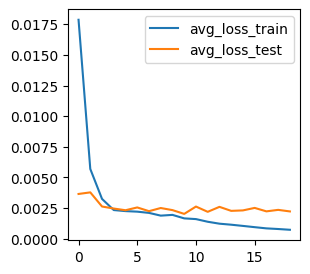

In [27]:
history = loss["history"]
history.to_csv("history.csv")
history[["avg_loss_train", "avg_loss_test"]].plot()

In [28]:

from ml_utility_loss.loss_learning.estimator.pipeline import eval
#eval_loss = loss["eval_loss"]

batch_size = params["batch_size_low"] if "batch_size_low" in params else params["batch_size"]

eval_loss = eval(
    test_set, model,
    batch_size=batch_size,
)

/opt/conda/lib/python3.10/site-packages/ml_utility_loss/loss_learning/estimator/process.py:348: UserWarning: cov(): degrees of freedom is <= 0 (Triggered internally at ../aten/src/ATen/native/Correlation.cpp:100.)
  corr_mat = torch.corrcoef(stack)


In [29]:
import pandas as pd

metrics = pd.DataFrame(eval_loss["model_metrics"]).T
metrics.to_csv("eval.csv")
metrics

avg_g_cos_loss  avg_g_mag_loss  avg_loss  grad_duration  grad_mae  \
lct_gan        0.009699             NaN  0.001272       2.597927  0.031054   

         grad_mape  grad_rmse  mean_pred_loss  pred_duration  pred_mae  \
lct_gan   0.586348   0.040936        0.000002       3.133333  0.028224   

         pred_mape  pred_rmse  pred_std  std_loss  total_duration  
lct_gan   0.067421   0.035662   0.05482  0.022214         5.73126

In [30]:
from ml_utility_loss.util import clear_memory
clear_memory()

In [31]:
#"""
from ml_utility_loss.loss_learning.estimator.process import pred, pred_2
from ml_utility_loss.util import stack_samples

#samples = test_set[list(range(len(test_set)))]
#y = {m: pred(model[m], s) for m, s in samples.items()}
y = pred_2(model, test_set, batch_size=batch_size)
#"""

Caching in ../../../../contraceptive/_cache_test/lct_gan/all inf False


/opt/conda/lib/python3.10/site-packages/ml_utility_loss/loss_learning/estimator/process.py:348: UserWarning: cov(): degrees of freedom is <= 0 (Triggered internally at ../aten/src/ATen/native/Correlation.cpp:100.)
  corr_mat = torch.corrcoef(stack)


In [32]:
import os
import pandas as pd
from ml_utility_loss.util import transpose_dict

os.makedirs("pred", exist_ok=True)
y2 = transpose_dict(y)
for k, v in y2.items():
    df = pd.DataFrame(v)
    df.to_csv(f"pred/{k}.csv")

In [33]:
print({k: sum(v["pred"])/len(v["pred"]) for k, v in y.items()})

{'lct_gan': 0.44455916152562114}


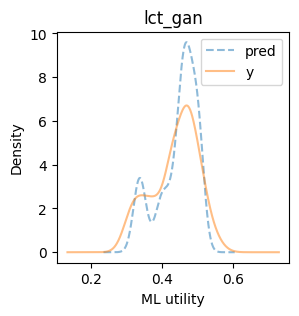

In [34]:
from ml_utility_loss.loss_learning.visualization import plot_pred_density_2

_ = plot_pred_density_2(y)

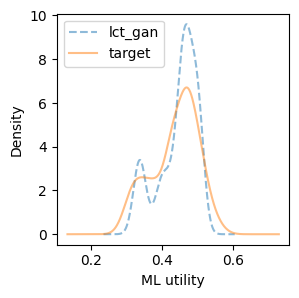

In [35]:
from ml_utility_loss.loss_learning.visualization import plot_density_3

_ = plot_density_3(y2["pred"], next(iter(y2["y"].values())))

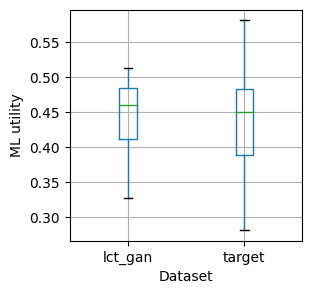

In [36]:
from ml_utility_loss.loss_learning.visualization import plot_box_3

_ = plot_box_3(y2["pred"], next(iter(y2["y"].values())))

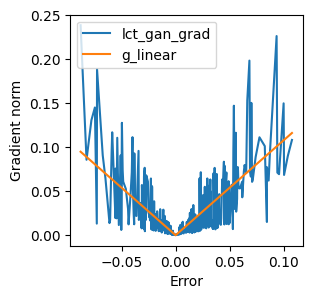

In [37]:
#"""
from ml_utility_loss.loss_learning.visualization import plot_grad, plot_grad_2, plot_grad_3
import matplotlib.pyplot as plt

#plot_grad_2(y, model.models)
for m in model.models:
    ym = y[m]
    fig, ax = plt.subplots()
    plot_grad_3(ym["error"], ym["grad"], name=f"{m}_grad", fig=fig, ax=ax)
#"""